In [129]:
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Bitcoin

In [98]:
btc = pd.read_csv('/content/drive/MyDrive/coins/btc.csv')
btc.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,Asset,Count,Open,High,Low,Close,Volume,...,Target,time,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,0,0,1514764860,Bitcoin,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,...,-0.014643,2018-01-01 00:01:00,0,0,1,1,2018,1,1,1
1,1,2,1514764920,Bitcoin,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,...,-0.015037,2018-01-01 00:02:00,0,0,1,1,2018,1,1,1
2,2,4,1514764980,Bitcoin,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,...,-0.010309,2018-01-01 00:03:00,0,0,1,1,2018,1,1,1
3,3,6,1514765040,Bitcoin,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,...,-0.008999,2018-01-01 00:04:00,0,0,1,1,2018,1,1,1
4,4,8,1514765100,Bitcoin,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,...,-0.008079,2018-01-01 00:05:00,0,0,1,1,2018,1,1,1


In [99]:
btc.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'timestamp', 'Asset', 'Count', 'Open',
       'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target', 'time', 'hour',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear'],
      dtype='object')

In [146]:
def removeUnnamed(data):
  """
  removeUnnamed: Removes the unnamed columns which was created during data preprocessing
  Input : DataFrame
  Output : DataFrame with Unnamed Columns dropped
  """
  data.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)
  return data

def getDate(data):
  """
  getDate: Creates a new column containing the date for particular instance
  Input : DataFrame
  Output : DataFrame with Date Column
  """
  data['date'] = pd.to_datetime(data['timestamp'], unit='s').dt.date
  data = data.set_index('date')
  return data

def getRequired(data):
  """
  getRequired: Retrieves only the required columns
  Input : DataFrame
  Output : DataFrame with required columns only
  """
  return data[['Open', 'High', 'Low', 'Close', 'Volume']]

def traintestSplit(data, test_size=0.2):
  """
  traintestSplit: Splits the dataset into train/test dataset
  Input : DataFrame
  Output : Two dataframe, train and test respectively
  """
  split_row = len(data) - int(test_size * len(data))
  train = data.iloc[:split_row]
  test = data.iloc[split_row:]
  return train, train

def zerobaseNormalize(data):
  """
  traintestSplit: Splits the dataset into train/test dataset
  Input : DataFrame
  Output : Two dataframe, train and test respectively
  """
  return data / data.iloc[0] - 1

def minmaxNormalize(data):
  return (data - data.min()) / (data.max() - data.min())

def extract_window_data(data, window_len=5, zero_base=True):
  window_data = []
  for i in range(len(data) - window_len):
      tmp = data[i: (i + window_len)].copy()
      tmp = zerobaseNormalize(tmp)
      window_data.append(tmp.values)
  return np.array(window_data)

def prepare_data(data, target, window_len=10, zero_base=True, test_size=0.2):
  train_data, test_data = traintestSplit(data, test_size=test_size)

  X_train = extract_window_data(train_data, window_len, zero_base)
  X_test = extract_window_data(test_data, window_len, zero_base)
  y_train = train_data[target][window_len:].values
  y_test = test_data[target][window_len:].values

  if zero_base:
      y_train = y_train / train_data[target][:-window_len].values - 1
      y_test = y_test / test_data[target][:-window_len].values - 1

  return train_data, test_data, X_train, X_test, y_train, y_test

def buildModel(input_data, output_size):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(100, input_shape=(input_data.shape[1], input_data.shape[2])))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=output_size, activation = 'linear'))

  model.compile(loss='mse', optimizer='adam', metrics = ['accuracy'])
  return model

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
  fig, ax = plt.subplots(1, figsize=(13, 7))
  ax.plot(line1, label=label1, linewidth=lw)
  ax.plot(line2, label=label2, linewidth=lw)
  ax.set_ylabel('price [CAD]', fontsize=14)
  ax.set_title(title, fontsize=16)
  ax.legend(loc='best', fontsize=16)

def runAll(data):
  data = removeUnnamed(data)
  data = getDate(data)
  data = getRequired(data)
  return data

In [101]:
btc = runAll(btc)

In [102]:
btc

,Open,High,Low,Close,Volume
date,,,,,
2018-01-01,13835.194000,14013.800000,13666.11,13850.176000,31.550062
2018-01-01,13835.036000,14052.300000,13680.00,13828.102000,31.046432
2018-01-01,13823.900000,14000.400000,13601.00,13801.314000,55.061820
2018-01-01,13802.512000,13999.000000,13576.28,13768.040000,38.780529
2018-01-01,13766.000000,13955.900000,13554.44,13724.914000,108.501637
...,...,...,...,...,...
2021-09-20,42983.780000,43001.850849,42878.26,42899.012857,56.850913
2021-09-20,42904.197143,42932.000000,42840.16,42860.005714,80.993326
2021-09-20,42859.385714,42887.500000,42797.20,42827.020000,65.677734


In [52]:
btc['date'] = str(btc['date'])

In [104]:
train, test, X_train, X_test, y_train, y_test = prepare_data(btc, 'Close', window_len=5)

In [110]:
model = buildModel(X_train, output_size=1)

In [111]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, shuffle=True)

Epoch 1/20
48907/48907 [==============================] - 386s 8ms/step - loss: 1.0098e-05 - accuracy: 3.8977e-05
Epoch 2/20
48907/48907 [==============================] - 373s 8ms/step - loss: 1.8323e-06 - accuracy: 3.8977e-05
Epoch 3/20
48907/48907 [==============================] - 374s 8ms/step - loss: 1.7535e-06 - accuracy: 3.8977e-05
Epoch 4/20
48907/48907 [==============================] - 386s 8ms/step - loss: 1.7221e-06 - accuracy: 3.8977e-05
Epoch 5/20
48907/48907 [==============================] - 384s 8ms/step - loss: 1.7084e-06 - accuracy: 3.8977e-05
Epoch 6/20
48907/48907 [==============================] - 377s 8ms/step - loss: 1.6842e-06 - accuracy: 3.8977e-05
Epoch 7/20
48907/48907 [==============================] - 386s 8ms/step - loss: 1.6914e-06 - accuracy: 3.8977e-05
Epoch 8/20
48907/48907 [==============================] - 380s 8ms/step - loss: 1.6623e-06 - accuracy: 3.8977e-05
Epoch 9/20
48907/48907 [==============================] - 380s 8ms/step - loss: 1.6808e-

In [112]:
history

In [113]:
import joblib

In [118]:
!mkdir '/content/drive/MyDrive/Models'
!mkdir '/content/drive/MyDrive/Models/crypto-price-pred'

In [119]:
joblib.dump(model, '/content/drive/MyDrive/Models/crypto-price-pred/BaseLine-Crypto.h5')

['/content/drive/MyDrive/Models/crypto-price-pred/BaseLine-Crypto.h5']

In [120]:
joblib.dump(model, '/content/drive/MyDrive/Models/crypto-price-pred/BaseLine-Crypto.pkl')

['/content/drive/MyDrive/Models/crypto-price-pred/BaseLine-Crypto.pkl']

In [131]:
# y_test = test['Close'][20:]
y_pred = model.predict(X_test).squeeze()

In [144]:
y_test = test['Close'][5:]

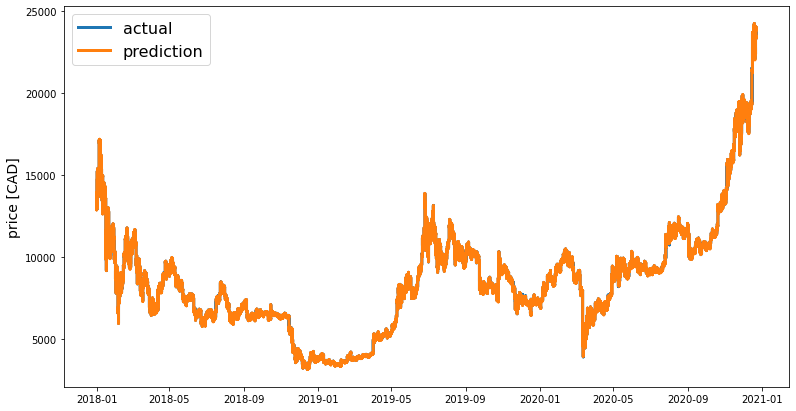

In [145]:
preds = test['Close'].values[:-5] * (y_pred + 1)
preds = pd.Series(index=y_test.index, data=preds)
line_plot(y_test, preds, 'actual', 'prediction', lw=3)

In [147]:
mean_absolute_error(preds, y_test)

6.42492623506962

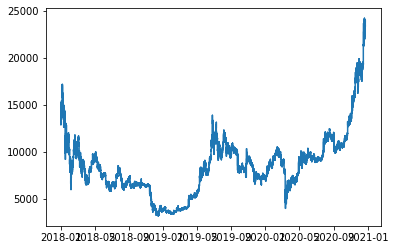

In [148]:
plt.plot(preds)

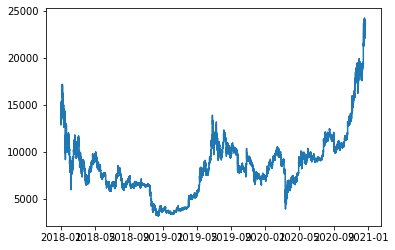

In [149]:
plt.plot(y_test)

In [152]:
len(X_test), len(X_train)

(1565021, 1565021)

In [153]:
model.predict(X_test[-20:])

array([[ 2.8986840e-03],
       [ 4.9466104e-04],
       [ 6.8303716e-04],
       [-1.2760595e-04],
       [-1.4765449e-03],
       [ 2.2537936e-04],
       [ 5.9448858e-04],
       [ 1.5084923e-03],
       [ 2.0411860e-03],
       [ 2.0279658e-03],
       [ 5.7273282e-04],
       [ 4.6461218e-04],
       [ 2.0174359e-03],
       [ 2.9702494e-03],
       [ 1.7352658e-03],
       [ 1.3698741e-03],
       [-9.0387097e-05],
       [-1.1186994e-03],
       [-3.1574718e-03],
       [-4.2572152e-03]], dtype=float32)

In [ ]:
a = X_test[:-20]
b = X_test[]

In [156]:
pd.DataFrame(X_test[-20:][0])

,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.000052,0.000372,0.000013,0.000491,-0.018198
2,0.000669,0.001324,0.000725,0.001509,0.445563
3,0.001547,0.001730,0.001650,0.001964,0.238785
4,0.002073,0.002807,0.002145,0.002602,0.168810
